<a href="https://colab.research.google.com/github/ayanga1998/COVID-19-CT-Scan-Classification/blob/main/CNN_COVID_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network for COVID-19 Diagnosis using CT Scan Images

**Notebook by Arnold Yanga**


As we have experienced over the last year and a half, the coronavirus has brought society an unprecedented set of challenges across all levels of society. At the start of the pandemic, one of the largest bottlenecks in mitigating the spread of COVID was the availability, or lack thereof, of effective diagnostic tests. Today, we have access to tests and even then, results have been met with skepticism. While the utility of tests cannot be disputed in terms of the pandemic, it becomes clear that as variants arise, tests must be adjusted to handle the so-called "classification drift". Deep learning methods can be applied as another step in the validation for the presence in COVID for patients admitted into hospitals. As variants arise, it may be useful for hospitals to leverage deep learning to make the verification process robust. 

The dataset used for this project contains CT images containing clinical findings of COVID-19 from nearly 1000 patients. The dataset was gathered by researchers from UCSD and was made publicly available on Github. Below I've attached the link to the repository along with a link to the preprint describing the dataset

**Github Repository:** [COVID-19 CT Scan Dataset](https://github.com/UCSD-AI4H/COVID-CT)

**Dataset Pre-print:** [Arxiv Link](https://arxiv.org/pdf/2003.13865.pdf)



## Overview

1. Data Pre-Processing
2. Initial Model Development
3. Data Augmentation
4. Transfer Learning

## 1. Preprocessing the Data
**Overview**


*   Import all dependencies
*   Extract file links from database and split into training, validation, and test partitions (60/20/20 split)
*   Establish Dataset Class to process and load images in mini-batches




In [1]:
!pip install torchinfo

In [2]:
import os  
import glob
import sklearn
from sklearn.model_selection import train_test_split

import PIL 
import numpy as np
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
from torchinfo import summary 

import torch.optim as optim
from IPython.display import Image
from torch.utils.data import DataLoader, Dataset

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

import cv2

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
random_seed = 124
np.random.seed(random_seed)

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

Extract file links for both labels and perform split the data into train, validation, and test partitions

In [6]:
path = '/content/drive/MyDrive/Data/COVID/'

pos_files = glob.glob(os.path.join(path, "CT_COVID",'*.*'))
neg_files = glob.glob(os.path.join(path, 'CT_NonCOVID','*.*'))

images = pos_files + neg_files
labels = np.array([1]*len(pos_files)+[0]*len(neg_files))

images_tv, images_test, y_tv, y_test  = train_test_split(images, labels, shuffle=True, test_size=0.2, random_state=123)
images_train, images_val, y_train, y_val  = train_test_split(images_tv, y_tv, shuffle=True, test_size=0.25, random_state=123)

Plot a few sample images

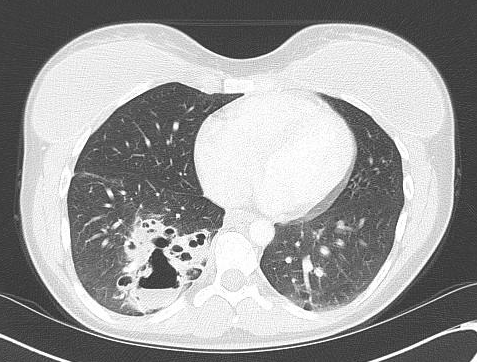

In [7]:
Image(images_train[1])
Image(images_train[15])
Image(images_train[66])

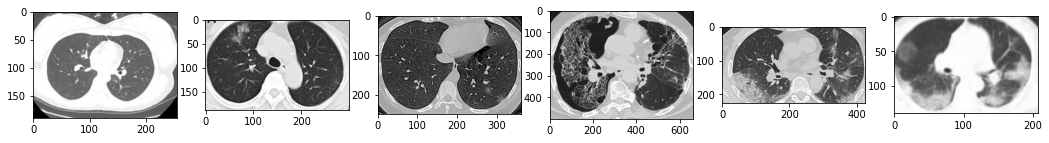

In [8]:
im = [cv2.imread(images_train[i]) for i in range(6)]

fig,ax = plt.subplots(ncols=6, figsize=(18,6))
for i in range(len(im)):
    ax[i].imshow(im[i],cmap='gray')

plt.show()

Based on the output below, we are working with a balanced but relatively small dataset of images

In [9]:
print(f'Number of samples in each set (train, val, test): {len(y_train), len(y_val), len(y_test)}')

print(f'Number of positive samples in each set: {y_train.sum(), y_val.sum(), y_test.sum()}')

Number of samples in each set (train, val, test): (447, 149, 150)
Number of positive samples in each set: (207, 71, 71)


### 1.1 Datasset Class
**Image Transformations**: Convert images to grayscale, resize images to 250 x 250 and transform to tensor\
**Get Item**: Only load images for each minibatch when called to save computational resources

In [10]:
class CT_Dataset(Dataset):
    def __init__(self, img_path, img_labels, img_transforms=None, grayscale=True):
        self.img_path = img_path
        self.img_labels = torch.Tensor(img_labels)
        if (img_transforms is None) & (grayscale == True):
            self.transforms = transforms.Compose([transforms.Grayscale(),
                                                  transforms.Resize((250, 250)),
                                                  transforms.ToTensor()])
        elif grayscale == False:
            self.transforms = transforms.Compose([transforms.Resize((250, 250)),
                                                  transforms.ToTensor()])
        else:
            self.transforms = img_transforms
    
    def __getitem__(self, index):
        # load image
        cur_path = self.img_path[index]
        cur_img = PIL.Image.open(cur_path).convert('RGB')
        cur_img = self.transforms(cur_img)

        return cur_img, self.img_labels[index]
    
    def __len__(self):
        return len(self.img_path)

## 2. Model Development


### 2.1 Network Configuration

The model used for this exercise has several key layers:


*   Conv2D $\rightarrow$ Batch Normalization $\rightarrow$ ReLU Activation $\rightarrow$ AvgPooling2D
  * Output Channels: 64
  * Filter Size: 3x3
  * AvgPooling Filter Size: 2x2
*   Conv2D $\rightarrow$ Batch Normalization $\rightarrow$ ReLU Activation $\rightarrow$ AvgPooling2D
  * Output Channels: 128
  * Filter Size: 3x3
  * AvgPooling Filter Size: 2x2
*   Conv2D $\rightarrow$ Batch Normalization $\rightarrow$ ReLU Activation $\rightarrow$ AvgPooling2D
  * Output Channels: 256
  * Filter Size: 3x3
  * AvgPooling Filter Size: 2x2
*   Conv2D $\rightarrow$ Batch Normalization $\rightarrow$ ReLU Activation $\rightarrow$ AvgPooling2D
  * Output Channels: 512
  * Filter Size: 3x3
  * AvgPooling Filter Size: 2x2
*   Conv2D $\rightarrow$ Batch Normalization $\rightarrow$ ReLU Activation $\rightarrow$ AvgPooling2D $\rightarrow$ Flatten
  * Output Channels: 512
  * Filter Size: 3x3
  * AvgPooling Filter Size: 2x2
  * Output Shape (After Flatten): (Batch Size, 1600)

After the series of convolutions, we pass the parameters through a series of Dropout, Linear, and ReLU layers and produce an output of shape (Batch Size, 1)
*   Dropout $\rightarrow$ Linear $\rightarrow$ ReLU Activation $\rightarrow$ Dropout $\rightarrow$ Linear $\rightarrow$ ReLU Activation $\rightarrow$ Linear $\rightarrow$ ReLU Activation $\rightarrow$ Linear
  * Dropout Ratio: 0.5



In [11]:
# define CNN mode
class Convnet(nn.Module):
    
    def __init__(self, dropout=0.5):
        super(Convnet, self).__init__()
        self.convnet = nn.Sequential(
          # input (num_batch, 1, 250, 250)
          nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3),  # (num_batch, 64, 248, 248)
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),  # (num_batch, 64, 124, 124)

          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3), # (num_batch, 128, 122, 122)
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),  # (num_batch, 128, 61, 61)

          nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3), # (num_batch, 256, 59, 59)
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),  # (num_batch, 256, 29, 29)

          nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3), # (num_batch, 128, 27, 27)
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),  # (num_batch, 128, 13, 13)

          nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3), # (num_batch, 64, 11, 11)
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),  # (num_batch, 64, 5, 5)
          nn.Flatten() # (num_batch, 1600)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),  # Dropout before first linear layer since it has a large number of trainable parameters
            nn.Linear(in_features= 12800, out_features=512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=1)
        )
    def forward(self, x):
        x = self.convnet(x)
        x = self.classifier(x)
        return x

#### Print model summary to  visualize network structure

In [12]:
vision_model = Convnet()
summary(vision_model, (32, 1, 250, 250))

Layer (type:depth-idx)                   Output Shape              Param #
Convnet                                  --                        --
├─Sequential: 1-1                        [32, 12800]               --
│    └─Conv2d: 2-1                       [32, 64, 248, 248]        640
│    └─BatchNorm2d: 2-2                  [32, 64, 248, 248]        128
│    └─ReLU: 2-3                         [32, 64, 248, 248]        --
│    └─MaxPool2d: 2-4                    [32, 64, 124, 124]        --
│    └─Conv2d: 2-5                       [32, 128, 122, 122]       73,856
│    └─BatchNorm2d: 2-6                  [32, 128, 122, 122]       256
│    └─ReLU: 2-7                         [32, 128, 122, 122]       --
│    └─MaxPool2d: 2-8                    [32, 128, 61, 61]         --
│    └─Conv2d: 2-9                       [32, 256, 59, 59]         295,168
│    └─BatchNorm2d: 2-10                 [32, 256, 59, 59]         512
│    └─ReLU: 2-11                        [32, 256, 59, 59]         --
│ 

### 2.2 Model Training Procedure
The training sequence used for our CNN model is summarized below:


*   **Loss Function**: *Binary Cross Entropy w/ Logistic Loss*
*   **Optimizer**: *Adam Optimization*
  * To fight overfitting the following methods were used:
      * **L2 Regularization**: Weight regularization using L2 Norm
      * **Learning Schedule**: *Decrease the learning rate* over a set period of epochs

Parameters used for training:


*   **Initial Learning Rate**: 0.0002
*   Learning Schedule: 
  * **Gamma**: 0.5
  * **Patience**: 7 epochs
*   **Number of Epochs**: 35
*   **Batch Size**: 32
*   **L2 Weight Decay**: 0.09






In [13]:
# define training function

def train_model(model, train_dataset, val_dataset, test_dataset, device, 
                lr=0.0001, epochs=30, batch_size=32, l2=0.00001, gamma=0.5,
                patience=7):
  model = model.to(device)

  # construct dataloader
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

  # history
  history = {'train_loss': [],
             'train_acc': [],
             'val_loss': [],
             'val_acc': []}

  # set up loss function and optimizer
  criterion = nn.BCEWithLogitsLoss()  
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)  # pass in the parameters to be updated and learning rate
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=patience, gamma=gamma)

  # Training Loop
  print("Training Start:")
  for epoch in range(epochs):
    model.train()  # start to train the model, activate training behavior

    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    for i, (images, labels) in enumerate(train_loader):
      # reshape images
      images = images.to(device)  # reshape: from (128, 1, 28, 28) -> (128, 28 * 28) = (128, 284), move batch to device
      labels = labels.to(device)  # move to device
      # forward
      outputs = model(images).view(-1)  # forward
      pred = torch.sigmoid(outputs)
      pred = torch.round(pred)
    
      cur_train_loss = criterion(outputs, labels)  # loss
      cur_train_acc = (pred == labels).sum().item() / batch_size

      # backward
      cur_train_loss.backward()   # run back propagation
      optimizer.step()            # optimizer update all model parameters
      optimizer.zero_grad()       # set gradient to zero, avoid gradient accumulating

      # loss
      train_loss += cur_train_loss 
      train_acc += cur_train_acc
        
    # valid
    model.eval()  # start to train the model, activate training behavior
    with torch.no_grad():  # tell pytorch not to update parameters
      for images, labels in val_loader:
        # calculate validation loss
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images).view(-1)

        # loss
        cur_valid_loss = criterion(outputs, labels)
        val_loss += cur_valid_loss
        # acc
        pred = torch.sigmoid(outputs)
        pred = torch.round(pred)
        val_acc += (pred == labels).sum().item() / batch_size

    # learning schedule step
    scheduler.step()

    # print training feedback
    train_loss = train_loss / len(train_loader)
    train_acc = train_acc / len(train_loader)
    val_loss = val_loss / len(val_loader)
    val_acc = val_acc / len(val_loader)

    print(f"Epoch:{epoch + 1} / {epochs}, lr: {optimizer.param_groups[0]['lr']:.5f} train loss:{train_loss:.5f}, train acc: {train_acc:.5f}, valid loss:{val_loss:.5f}, valid acc:{val_acc:.5f}")
    
    # update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
  test_acc = 0

  with torch.no_grad():
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)

      # calculate outputs by running images through the network
      outputs = model(images)

      # the class with the highest energy is what we choose as prediction
      pred = torch.sigmoid(outputs)
      pred = torch.round(pred)
      test_acc += (pred == labels).sum().item()

  print(f'Test Accuracy:  {(test_acc / len(test_loader))}')

  return history

Train the model

In [14]:
# Load the data
train_dataset = CT_Dataset(img_path=images_train, img_labels=y_train)
val_dataset = CT_Dataset(img_path=images_val, img_labels=y_val)
test_dataset = CT_Dataset(img_path=images_test, img_labels=y_test)

# Train the CNN model
cnn_model = Convnet(dropout=0.5)
hist = train_model(cnn_model, train_dataset, val_dataset, test_dataset, device, lr=0.0002, batch_size=32, epochs=35, mom=0.8, l2=0.09, patience=5)

Training Start:
Epoch:1 / 35, lr: 0.00020 train loss:0.67902, train acc: 0.57589, valid loss:0.69638, valid acc:0.48750
Epoch:2 / 35, lr: 0.00020 train loss:0.62791, train acc: 0.62500, valid loss:0.72904, valid acc:0.48750
Epoch:3 / 35, lr: 0.00020 train loss:0.58997, train acc: 0.67857, valid loss:0.67020, valid acc:0.50000
Epoch:4 / 35, lr: 0.00020 train loss:0.53748, train acc: 0.72991, valid loss:0.62751, valid acc:0.59375
Epoch:5 / 35, lr: 0.00010 train loss:0.49760, train acc: 0.75893, valid loss:0.53264, valid acc:0.65625
Epoch:6 / 35, lr: 0.00010 train loss:0.40326, train acc: 0.81250, valid loss:0.66953, valid acc:0.59375
Epoch:7 / 35, lr: 0.00010 train loss:0.37562, train acc: 0.83705, valid loss:0.53254, valid acc:0.70625
Epoch:8 / 35, lr: 0.00010 train loss:0.32686, train acc: 0.86607, valid loss:0.45203, valid acc:0.73125
Epoch:9 / 35, lr: 0.00010 train loss:0.25004, train acc: 0.91964, valid loss:0.48666, valid acc:0.72500
Epoch:10 / 35, lr: 0.00005 train loss:0.22030, t

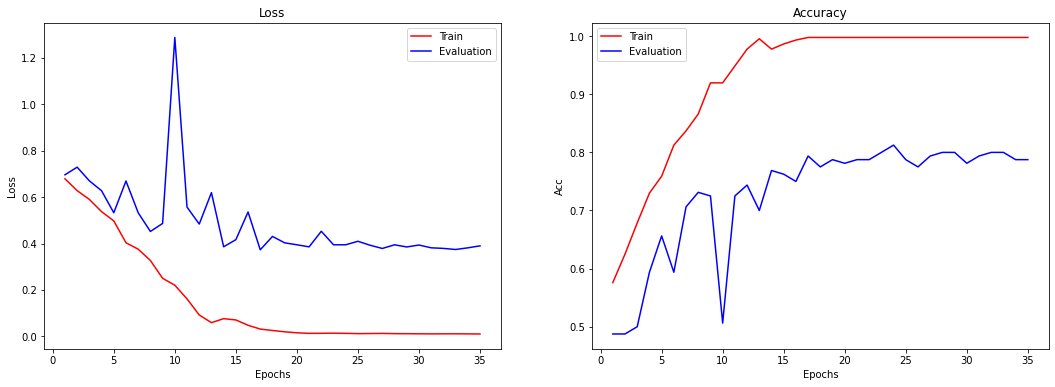

In [15]:
# plot training curves
epochs = range(1, len(hist['train_loss']) + 1)

fig, ax = plt.subplots(1,2, figsize=(18,6))
ax[0].plot(epochs, hist['train_loss'], 'r-', label='Train')
ax[0].plot(epochs, hist['val_loss'], 'b-', label='Evaluation')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()


ax[1].plot(epochs, hist['train_acc'], 'r-', label='Train')
ax[1].plot(epochs, hist['val_acc'], 'b-', label='Evaluation')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Acc')
ax[1].legend()

plt.show()

#### Results For Initial Model

The learning curves shown above show reasonable results.

**Observations** 


*   The model begins to overfit on the training data after 10 epochs
*   Training Accuracy generally reaches around 99\% relatively quickly
* Validation accuracy stabilizes at around 78\%.
* Training loss converges to near zero
* Validation loss converges around 0.4
* Accuracy on the test set is 81.3\%

Overall, our first model achieved an accuracy of 81.3\% for our hold out set. Given the size of our network and the lack of available data, these results are quite satisfying. With that being said, we cannot ignore the fact that our model overfits quite early in training. Since we achieve a near perfect score for training, I have no doubt we can continue to tune this model and achieve even better results on our hold-out set

**Considerations to fight overfitting**


*   Add L1 Regularization
*   Data Augmentation (see next section)
*   Transfer Learning (see later sections)
  * Utilize pre-trained models built to address medical images since we have such a small amount of data
*   More hyperparameter tuning



## 3. Data Augmentation

Data Augmentation is a technique used to either diversify a training set or add more samples to it. To augment an image is to apply specified transformation to the pixels of the image array. Examples of augmentations include rescaling, resizing, and translating the image to name a few. Implementing these augmentationss in PyTorch is quite straightforward. In this section we will apply augmentations on the entire dataset as well as a fraction of our data to generate "new" samples to add to our dataset and run our model to compare performance.

#### Augmentations Used
* **Grayscale**
* **Resize** $\rightarrow$ 250 x 250
* **RandomAffine**
  * **Translate**: Width $\rightarrow$ 0.01, Height $\rightarrow$ 0.001
  * **Image Scaling**: Width $\rightarrow$ 1.2x, Height $\rightarrow$ 1.2x
  * **Shear**: 0.9
* **RandomRotation**: 20 degrees
* **Convert Image to Tensor**

Before Transformation


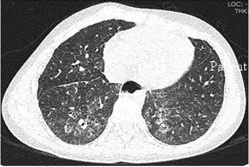


After Transformation


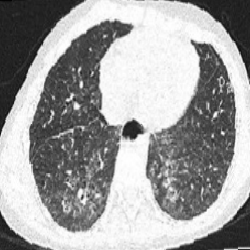

In [17]:
img = PIL.Image.open(images_train[10])

img_trans = transforms.Compose([transforms.Grayscale(),
                                transforms.RandomRotation(5),
                                transforms.Resize((250, 250)),
                                transforms.RandomAffine(degrees=0, scale=(1.1, 1.1), shear=0.9),
                                transforms.ToTensor()
                                ])
trans = img_trans(img)

print('Before Transformation')
display(img)
print('\nAfter Transformation')
display(transforms.ToPILImage()(trans))

### 3.1 Data Augmentation Approach \#1 -- Augmenting the entire Training Set


In [18]:
train_dataset_full_aug = CT_Dataset(img_path=images_train, img_labels=y_train, img_transforms=img_trans)
val_dataset = CT_Dataset(img_path=images_val, img_labels=y_val)
test_dataset = CT_Dataset(img_path=images_test, img_labels=y_test)

In [22]:
# Train the CNN model
cnn_model = Convnet()
hist_full_aug = train_model(cnn_model, train_dataset_full_aug, val_dataset, 
                            test_dataset, device, lr=0.0001, batch_size=32, epochs=35,
                            gamma=0.75, l2=0.09, patience=15)

Training Start:
Epoch:1 / 35, lr: 0.00010 train loss:0.69482, train acc: 0.50670, valid loss:0.69270, valid acc:0.48750
Epoch:2 / 35, lr: 0.00010 train loss:0.67481, train acc: 0.59598, valid loss:0.69556, valid acc:0.48750
Epoch:3 / 35, lr: 0.00010 train loss:0.64372, train acc: 0.62500, valid loss:0.66434, valid acc:0.50000
Epoch:4 / 35, lr: 0.00010 train loss:0.62313, train acc: 0.65625, valid loss:0.66911, valid acc:0.53125
Epoch:5 / 35, lr: 0.00010 train loss:0.61303, train acc: 0.64732, valid loss:0.68600, valid acc:0.54375
Epoch:6 / 35, lr: 0.00010 train loss:0.57478, train acc: 0.70759, valid loss:0.67434, valid acc:0.55625
Epoch:7 / 35, lr: 0.00010 train loss:0.56617, train acc: 0.69643, valid loss:0.67474, valid acc:0.55625
Epoch:8 / 35, lr: 0.00010 train loss:0.54088, train acc: 0.72545, valid loss:0.83367, valid acc:0.54375
Epoch:9 / 35, lr: 0.00010 train loss:0.50129, train acc: 0.77902, valid loss:0.51248, valid acc:0.69375
Epoch:10 / 35, lr: 0.00010 train loss:0.47570, t

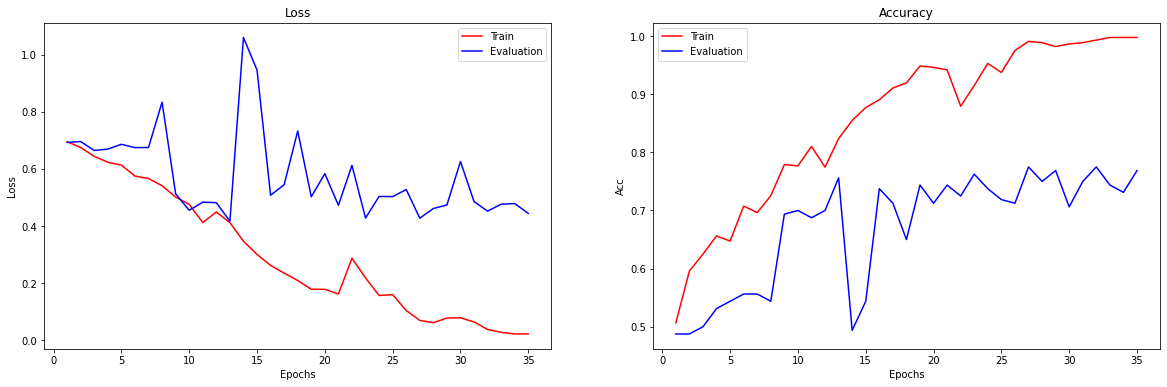

In [23]:
# plot training curves
epochs = range(1, len(hist_full_aug['train_loss']) + 1)

fig, ax = plt.subplots(1,2, figsize=(20,6))
ax[0].plot(epochs, hist_full_aug['train_loss'], 'r-', label='Train')
ax[0].plot(epochs, hist_full_aug['val_loss'], 'b-', label='Evaluation')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, hist_full_aug['train_acc'], 'r-', label='Train')
ax[1].plot(epochs, hist_full_aug['val_acc'], 'b-', label='Evaluation')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Acc')
ax[1].legend()

plt.show()

#### Results from Approach 1

**Observations**

*   Drop in overall accuracy for both training and validation sets
*   Validation loss has increased by 0.1 in comparison to the results with no augmentation
* The model generalizes worse on the validation set than previously and training performance has also suffered
* The test accuracy dropped by roughly 10 \%
* The drop in overall performance may suggest that perhaps lack of data could be a contributing factor




### 3.2 Data Augmentation Approach \#2 -- Concatenate Augmented Data to Original Dataset
In this approach, the aim is to see if adding augmented samples into our dataset can help fight overfitting. We know that our sample size is small, so perhaps adding variations of samples on top of our original data may allow our model to generalize better. In doing this, we also run the risk of increasing the bias of our model.


In the code below we will augment 60 images from the training set and 20 images from the validation set and concatenate them on the original data. 


In [25]:
train_dataset_og = CT_Dataset(img_path=images_train, img_labels=y_train)
train_dataset_aug = CT_Dataset(img_path=images_train[:60], img_labels=y_train[:60], img_transforms=img_trans)
train_dataset_fin = torch.utils.data.ConcatDataset([train_dataset_og,train_dataset_aug])

val_dataset_og = CT_Dataset(img_path=images_val, img_labels=y_val)
val_dataset_aug = CT_Dataset(img_path=images_val[:20], img_labels=y_val[:25], img_transforms=img_trans)
val_dataset_fin = torch.utils.data.ConcatDataset([val_dataset_og, val_dataset_aug])

test_dataset = CT_Dataset(img_path=images_test, img_labels=y_test)

In [26]:
print(len(train_dataset_fin))
print(len(val_dataset_fin))

507
169


In [31]:
# Train the CNN model
cnn_model = Convnet(dropout=0.5)
hist_concat = train_model(cnn_model, train_dataset_fin, val_dataset_fin, test_dataset, device, lr=0.0001, l2=0.09, batch_size=32, epochs=75)

Training Start:
Epoch:1 / 75, lr: 0.00010 train loss:0.68430, train acc: 0.51172, valid loss:0.69340, valid acc:0.46875
Epoch:2 / 75, lr: 0.00010 train loss:0.66090, train acc: 0.61328, valid loss:0.70945, valid acc:0.46875
Epoch:3 / 75, lr: 0.00010 train loss:0.61085, train acc: 0.67773, valid loss:0.67135, valid acc:0.47917
Epoch:4 / 75, lr: 0.00010 train loss:0.58772, train acc: 0.65625, valid loss:0.62099, valid acc:0.60938
Epoch:5 / 75, lr: 0.00010 train loss:0.52626, train acc: 0.72461, valid loss:0.52697, valid acc:0.63021
Epoch:6 / 75, lr: 0.00010 train loss:0.48032, train acc: 0.77539, valid loss:0.46698, valid acc:0.67188
Epoch:7 / 75, lr: 0.00005 train loss:0.44885, train acc: 0.78320, valid loss:0.54685, valid acc:0.64062
Epoch:8 / 75, lr: 0.00005 train loss:0.35709, train acc: 0.86328, valid loss:0.46354, valid acc:0.68229
Epoch:9 / 75, lr: 0.00005 train loss:0.26617, train acc: 0.90234, valid loss:0.47803, valid acc:0.68750
Epoch:10 / 75, lr: 0.00005 train loss:0.21208, t

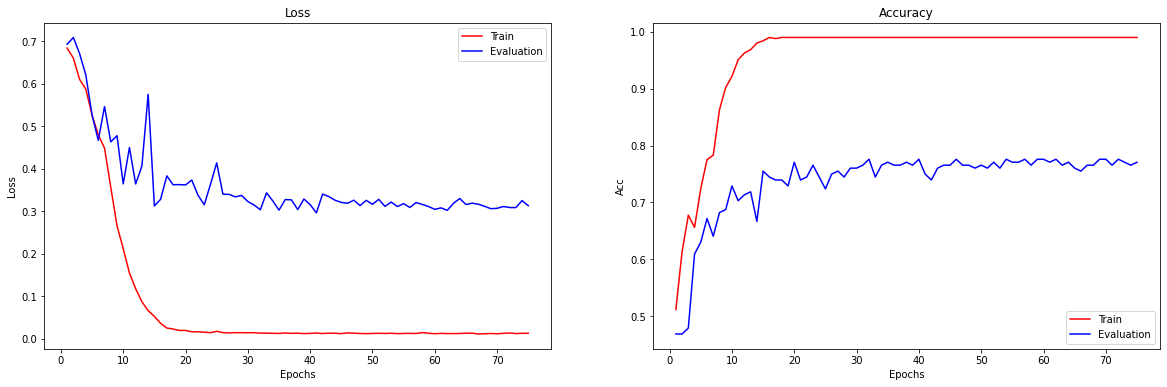

In [33]:
# plot training curves
epochs = range(1, len(hist_concat['train_loss']) + 1)

fig, ax = plt.subplots(1,2, figsize=(20,6))
ax[0].plot(epochs, hist_concat['train_loss'], 'r-', label='Train')
ax[0].plot(epochs, hist_concat['val_loss'], 'b-', label='Evaluation')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()


ax[1].plot(epochs, hist_concat['train_acc'], 'r-', label='Train')
ax[1].plot(epochs, hist_concat['val_acc'], 'b-', label='Evaluation')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Acc')
ax[1].legend()

plt.show()

#### Results from Approach 2 
**Observations**


*   Test Accuracy: 84\%
*   Distinct gap between training and validation results remain as learning plateaus after 20 epochs
*   The model achieves the highest accuracy for the hold out set compared to the previous models
*   Further investigation is needed to reduce the gap between training in validation sets 
*   It would be interesting to see how the model reacts to adding a greater portion of augmented samples on top of the original dataset


## 4. Transfer Learning (VGG-16)

In this section, we will use the VGG-16 model which is pretrained on Image-Net to leverage the pre-trained parameters for this particular classification task. To achieve this, we will load the vgg-16 model using the torchvision library and then freeze the parameters for the "features" portiion of the model. We will then create our own custom "classifier" sequence of dense layers to overwrite the pre-trained classifier parameters trained on Image-Net. In this way, we leverage the visual power of VGG-16 while still training the model to classify positive or negative instances of COVID-19 in CT imgaes.

In [34]:
import torchvision.models as models

VGG_model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In the cell below, we will visualize the VGG-16 Network structure. 

In [35]:
print(VGG_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Freeze the parameters for the convolutional layers and overwrite the VGG-16 Classifier

In [36]:
VGG_model = models.vgg16(pretrained=True)

for name, param in VGG_model.named_parameters():
  param.requires_grad = False

# define out classifier
binary_classifier = nn.Sequential(
   nn.Linear(in_features=25088, out_features=2048),
   nn.ReLU(),
   nn.Linear(in_features=2048, out_features=1024),
   nn.ReLU(),
   nn.Linear(in_features=1024, out_features=512),
   nn.ReLU(),
   nn.Linear(in_features=512, out_features=1)
)

# replace model class classifier attribute:
VGG_model.classifier = binary_classifier

Before we begin training, we need to prepare our images to be compatible with the VGG network. In particular, VGG-16 was built to handle color images, meaning the network processes our data using 3 channels for Red, Blue, and Green. Our dataset is a compilation of both color and grayscale images. In previous models, we handled this inconsistency by applying a grayscale transformation to the entire set. By setting the grayscale parameter for our dataset function to False, we can then transform our dataset to contain all color images.

With this done, we can then train our model and analyze the results



In [38]:
train_dataset = CT_Dataset(img_path=images_train, img_labels=y_train, grayscale=False)
val_dataset = CT_Dataset(img_path=images_val, img_labels=y_val, grayscale=False)
test_dataset = CT_Dataset(img_path=images_test, img_labels=y_test, grayscale=False)

# Train the CNN model
hist = train_model(VGG_model, train_dataset, val_dataset, test_dataset, device, lr=0.0001, batch_size=32, epochs=20, mom=0.8, l2=0.2
                   , patience=15)

Training Start:
Epoch:1 / 20, lr: 0.00010 train loss:0.67576, train acc: 0.55580, valid loss:0.66006, valid acc:0.67500
Epoch:2 / 20, lr: 0.00010 train loss:0.62390, train acc: 0.68973, valid loss:0.60276, valid acc:0.71875
Epoch:3 / 20, lr: 0.00010 train loss:0.54428, train acc: 0.80804, valid loss:0.53553, valid acc:0.78125
Epoch:4 / 20, lr: 0.00010 train loss:0.44257, train acc: 0.86607, valid loss:0.53511, valid acc:0.67500
Epoch:5 / 20, lr: 0.00010 train loss:0.37121, train acc: 0.88393, valid loss:0.44720, valid acc:0.77500
Epoch:6 / 20, lr: 0.00010 train loss:0.30069, train acc: 0.92188, valid loss:0.45782, valid acc:0.75625
Epoch:7 / 20, lr: 0.00010 train loss:0.25769, train acc: 0.95089, valid loss:0.40175, valid acc:0.79375
Epoch:8 / 20, lr: 0.00010 train loss:0.23846, train acc: 0.93973, valid loss:0.39593, valid acc:0.80000
Epoch:9 / 20, lr: 0.00010 train loss:0.20533, train acc: 0.97098, valid loss:0.40706, valid acc:0.76250
Epoch:10 / 20, lr: 0.00010 train loss:0.17773, t

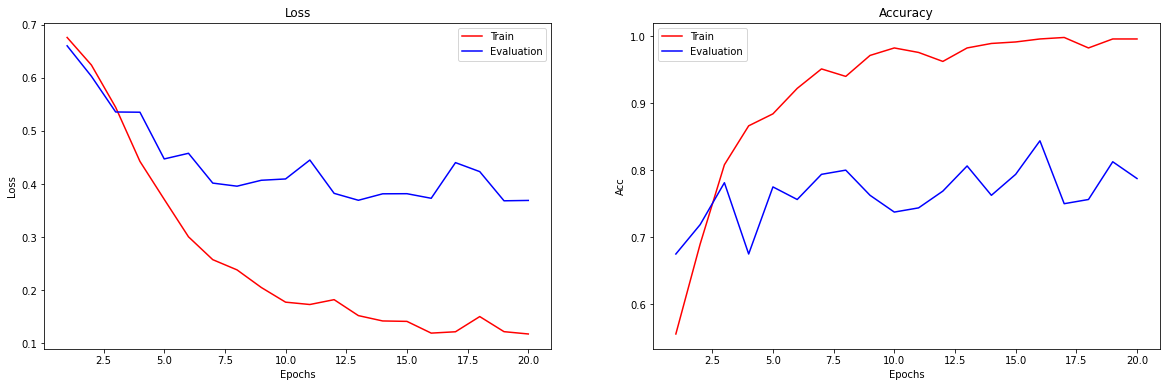

In [40]:
# plot training curves
epochs = range(1, len(hist['train_loss']) + 1)

fig, ax = plt.subplots(1,2, figsize=(20,6))
ax[0].plot(epochs, hist['train_loss'], 'r-', label='Train')
ax[0].plot(epochs, hist['val_loss'], 'b-', label='Evaluation')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()


ax[1].plot(epochs, hist['train_acc'], 'r-', label='Train')
ax[1].plot(epochs, hist['val_acc'], 'b-', label='Evaluation')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Acc')
ax[1].legend()

plt.show()

### Results from Transfer Learning

**Observations**:



*   Learning curves remain stable, however the model overfits on the training set after 7 epochs
*   Training loss converges to nearly 0.1 while validation loss plateaus at around 0.4 
*   Validation accuracy peaks at 0.84 but converges to around 0.8 at the end of training
*   Results on the test set yield an accuracy of 82\% which beats our initial model

Overall, the use of transfer learning for image classification is quite beneficial. VGG-16 provided us with just as good results even though the convolutional layers were trained on a completely different dataset. This showcases the power of transfer learning as we freezed the weights for the convolutional layers for this task. 

**Further Considerations**

After applying several different techniques and models to tackle the task of detecting the presence of COVID-19 in CT images, I am left with only more ideas on how to address this task from different angles. Logically, the next step would be to apply data augmentation techniques to our VGG-16 model and compare performance. Since concatenating our original training set with the augmented images yielded the best results on the test set, this would be a great starting point. From there, I would love to try different pre-trained models such as AlexNet and see how performance compares with VGG-16. After that, perhaps creating an interface where users can submit their own images and get results in real time would be an interesting way to deploy this model. Such a design could be useful for practitioners in the medical field. Finally-- it goes without saying that further data collection would be of the highest priority. With new variants being discovered, it is essential for any model to adjust to take this into account.






## Closing Remarks

If you've read up to this point, thanks for taking the time to explore my code! I hope you find my insights useful and I would love to hear any feedback/critique as I am always open to learn from the experiences of others. You can reach me at ayanga@stevens.edu !